# Electrode Analysis with Graph
This analysis is based on the steps carried out in ElectrodeDemo. The final graph shows the amount of unscathed gold by radius, which

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
plt.style.use('evanstyle.mplstyle')

In [2]:
x_min = -4
x_max = 50
y_min = 0
y_max = 6
grid_increment = 2
x_dim = int((x_max-x_min)/grid_increment + 1)
y_dim = int((y_max-y_min)/grid_increment + 1)

gold_area = np.ones((x_dim, y_dim))
gold_area = np.negative(gold_area)

In [3]:
indir = 'Gold Set 2/'
regex = re.compile(r'^y(\d+)_x(\d+)\.JPG$')
filenames = os.listdir(indir)
file_list = [f for f in map(regex.match, filenames) if f is not None]
df = pd.DataFrame()

In [4]:
for f in file_list:
    
    ds = pd.Series(dtype='float64')
    ds['x'] = int(f.group(2))
    #print(str(f.group(1)))
    ds['y'] = int(f.group(1))
    
    
    #load image
    #path_name = 'Gold Set 2/y{}_x{}.JPG'.format(j, i) #flipped
    #print(path_name)
    #src = cv2.imread(path_name)
    print(indir + f.group(0))
    src = cv2.imread(indir + f.group(0))
    
    if src is None: #shouldn't be
        continue
    
    #Create RGB, Grayscale, and Binary transformations
    original = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(imgray,55,255,cv2.THRESH_BINARY_INV)
    alpha = cv2.GaussianBlur(alpha, (21,21), cv2.BORDER_DEFAULT)
    
    #Using Hough Circle, find scope area
    hough_circle = cv2.HoughCircles(alpha, cv2.HOUGH_GRADIENT, 1.5, 100, param1=50,param2=30,minRadius=0,maxRadius=0)
    hough_circle = np.round(hough_circle[0, 0,:])
    (x,y) = (int(hough_circle[0]), int(hough_circle[1]))
    r = int(hough_circle[2])
    hc_area = np.pi*r**2
    
    #Delete all external area with bitwise_and
    circlemask = np.zeros(original.shape, dtype=np.uint8)
    cv2.circle(circlemask, (x,y), r, (255,255,255), -1)
    circlemask = cv2.cvtColor(circlemask,cv2.COLOR_BGR2GRAY)
    ROI = cv2.bitwise_and(original,original, mask=circlemask)
        
    #Transform to HSV, set upper and lower bounds of gold color, and find binary image with this gold range
    hsvimage = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
    lower = np.array([17, 137, 200], dtype="uint8")
    upper = np.array([50, 190, 255], dtype="uint8")
    goldmask = cv2.inRange(hsvimage, lower, upper)

    #Clean up binary image to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(goldmask, cv2.MORPH_OPEN, kernel, iterations=1)

    #Only consider contours with significant area, draw all contours
    cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnt_area = 0
    for c in cnts:
        currcontour = cv2.contourArea(c)
        if currcontour >= 2000:
            cnt_area += currcontour
            cv2.drawContours(ROI,[c], 0, (0,0,255), 2)
        
    #Calculating Area:
    perarea = cnt_area/hc_area
    #print('Contour area/Circle area = '+ str(cnt_area)+'/'+ str(hc_area)+' = ' +str(perarea))
    if perarea > 1:
        perarea = 1 
    #print(perarea)
        
    #insert into array
    
    #print(str(perarea))
    ds['area'] = perarea
    #print(ds)
    df = df.append(ds, ignore_index=True)
    #print(df)

Gold Set 2/y6_x8.JPG
Gold Set 2/y6_x50.JPG
Gold Set 2/y6_x44.JPG
Gold Set 2/y4_x20.JPG
Gold Set 2/y4_x34.JPG
Gold Set 2/y0_x14.JPG
Gold Set 2/y0_x28.JPG
Gold Set 2/y0_x16.JPG
Gold Set 2/y4_x22.JPG
Gold Set 2/y4_x36.JPG
Gold Set 2/y6_x46.JPG
Gold Set 2/y6_x42.JPG
Gold Set 2/y4_x32.JPG
Gold Set 2/y4_x26.JPG
Gold Set 2/y0_x12.JPG
Gold Set 2/y0_x10.JPG
Gold Set 2/y0_x38.JPG
Gold Set 2/y4_x30.JPG
Gold Set 2/y4_x24.JPG
Gold Set 2/y4_x8.JPG
Gold Set 2/y4_x18.JPG
Gold Set 2/y6_x40.JPG
Gold Set 2/y4_x42.JPG
Gold Set 2/y2_x12.JPG
Gold Set 2/y6_x26.JPG
Gold Set 2/y6_x32.JPG
Gold Set 2/y6_x18.JPG
Gold Set 2/y6_x24.JPG
Gold Set 2/y6_x30.JPG
Gold Set 2/y2_x38.JPG
Gold Set 2/y2_x10.JPG
Gold Set 2/y4_x40.JPG
Gold Set 2/y0_x8.JPG
Gold Set 2/y4_x44.JPG
Gold Set 2/y4_x50.JPG
Gold Set 2/y2_x28.JPG
Gold Set 2/y2_x14.JPG
Gold Set 2/y6_x34.JPG
Gold Set 2/y6_x20.JPG
Gold Set 2/y2_x8.JPG
Gold Set 2/y6_x36.JPG
Gold Set 2/y6_x22.JPG
Gold Set 2/y2_x16.JPG
Gold Set 2/y4_x46.JPG
Gold Set 2/y2_x6.JPG
Gold Set 2/y6_x

In [5]:
df = df.sort_values(by=['x'])
print(df)
print(df.y.unique())

        area     x    y
77  1.000000   0.0  6.0
51  1.000000   0.0  0.0
94  0.990104   0.0  4.0
59  0.952485   0.0  2.0
70  0.947528   2.0  2.0
..       ...   ...  ...
79  0.927856  46.0  2.0
91  1.000000  48.0  6.0
52  0.963623  48.0  4.0
34  0.432653  50.0  4.0
1   0.981121  50.0  6.0

[99 rows x 3 columns]
[6. 0. 4. 2.]


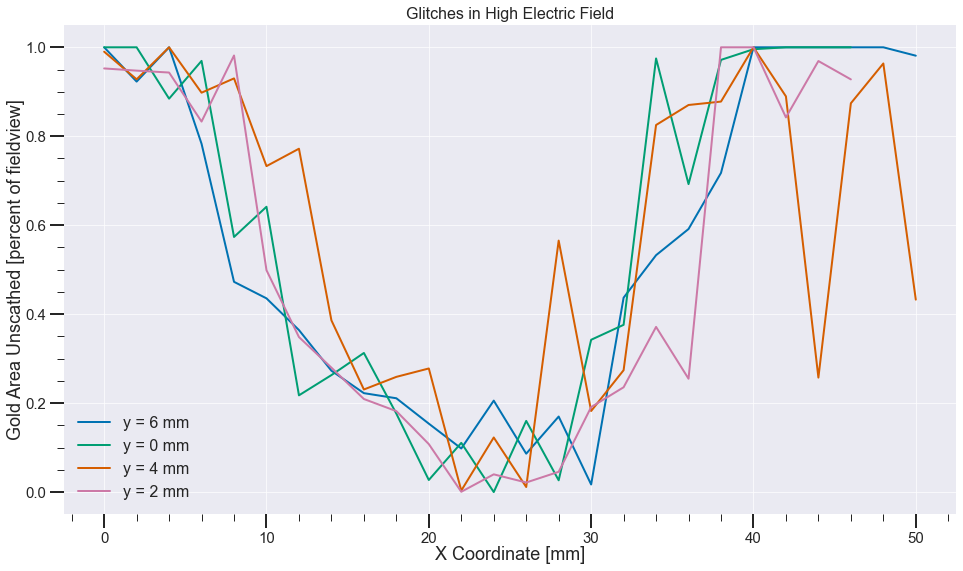

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
#fig.set_prop_cycle('color', colors)
for y in df.y.unique():
    mask = (df['y'] == y)
    xs = df['x'][mask]
    areas = df['area'][mask]
    ax.plot(xs, areas, label='y = %d mm' % y)
    
ax.set_xlabel("X Coordinate [mm]")
ax.set_ylabel("Gold Area Unscathed [percent of fieldview]")
ax.set_title("Glitches in High Electric Field")
ax.legend(loc="lower left")
plt.show()